In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.datasets import mnist

class GetMiniBatch:
    """
    Iterator to get mini-batches
    
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Training data
    y : ndarray, shape (n_samples, 1)
        Ground truth
    batch_size : int
        Batch size
    seed : int
        Random seed for NumPy
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int64)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

class ScratchSimpleNeuralNetrowkClassifier:
    """
    Simple three-layer neural network classifier
    
    Parameters
    ----------
    n_nodes1 : int
        Number of nodes in the first layer
    n_nodes2 : int
        Number of nodes in the second layer
    learning_rate : float
        Learning rate for gradient descent
    epochs : int
        Number of epochs
    batch_size : int
        Batch size
    activation : str
        Activation function ('sigmoid' or 'tanh')
    random_state : int
        Random seed for weight initialization
    verbose : bool
        If True, print progress during training
        
    Attributes
    ----------
    W1 : ndarray
        Weights for the first layer
    B1 : ndarray
        Bias for the first layer
    W2 : ndarray
        Weights for the second layer
    B2 : ndarray
        Bias for the second layer
    W3 : ndarray
        Weights for the third layer
    B3 : ndarray
        Bias for the third layer
    train_loss : list
        Training loss history
    val_loss : list
        Validation loss history
    """
    def __init__(self, n_nodes1=400, n_nodes2=200, learning_rate=0.01, 
                 epochs=10, batch_size=20, activation='tanh', 
                 random_state=0, verbose=True):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation = activation
        self.random_state = random_state
        self.verbose = verbose
        
        # Initialize parameters
        self.W1 = None  # First layer weights
        self.B1 = None  # First layer bias
        self.W2 = None  # Second layer weights
        self.B2 = None  # Second layer bias
        self.W3 = None  # Output layer weights
        self.B3 = None  # Output layer bias
        
        # History of loss
        self.train_loss = []
        self.val_loss = []
        
    def _initialize_parameters(self, n_features, n_output):
        """
        Initialize weights and biases with small random values
        
        Parameters
        ----------
        n_features : int
            Number of input features
        n_output : int
            Number of output classes
        """
        np.random.seed(self.random_state)
        sigma = 0.01  # Standard deviation for Gaussian distribution
        
        # Initialize weights and biases
        self.W1 = sigma * np.random.randn(n_features, self.n_nodes1)
        self.B1 = np.zeros(self.n_nodes1)
        
        self.W2 = sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = np.zeros(self.n_nodes2)
        
        self.W3 = sigma * np.random.randn(self.n_nodes2, n_output)
        self.B3 = np.zeros(n_output)
    
    def _activation_function(self, A):
        """
        Apply activation function
        
        Parameters
        ----------
        A : ndarray
            Input to the activation function
            
        Returns
        -------
        Z : ndarray
            Output after applying activation function
        """
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-A))
        elif self.activation == 'tanh':
            return np.tanh(A)
    
    def _activation_derivative(self, A):
        """
        Derivative of the activation function
        
        Parameters
        ----------
        A : ndarray
            Input to the activation function
            
        Returns
        -------
        derivative : ndarray
            Derivative of the activation function
        """
        if self.activation == 'sigmoid':
            sigmoid_A = self._activation_function(A)
            return sigmoid_A * (1 - sigmoid_A)
        elif self.activation == 'tanh':
            return 1 - np.tanh(A)**2
            
    def _softmax(self, A):
        """
        Softmax function for output layer
        
        Parameters
        ----------
        A : ndarray
            Input to the softmax function
            
        Returns
        -------
        Z : ndarray
            Probabilities after applying softmax
        """
        # Subtract max for numerical stability
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))
        return exp_A / np.sum(exp_A, axis=1, keepdims=True)
    
    def _cross_entropy_loss(self, y_true, y_pred):
        """
        Calculate cross-entropy loss
        
        Parameters
        ----------
        y_true : ndarray, shape (n_samples, n_classes)
            One-hot encoded ground truth
        y_pred : ndarray, shape (n_samples, n_classes)
            Predicted probabilities
            
        Returns
        -------
        loss : float
            Cross-entropy loss
        """
        # Add a small constant to avoid log(0)
        y_pred = np.clip(y_pred, 1e-10, 1.0)
        loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
        return loss
    
    def _forward_propagation(self, X):
        """
        Forward propagation pass
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input data
            
        Returns
        -------
        cache : dict
            Cache of all activations and pre-activations
        """
        # First layer
        A1 = np.dot(X, self.W1) + self.B1
        Z1 = self._activation_function(A1)
        
        # Second layer
        A2 = np.dot(Z1, self.W2) + self.B2
        Z2 = self._activation_function(A2)
        
        # Output layer
        A3 = np.dot(Z2, self.W3) + self.B3
        Z3 = self._softmax(A3)
        
        # Cache for backpropagation
        cache = {
            'X': X,
            'A1': A1, 'Z1': Z1,
            'A2': A2, 'Z2': Z2,
            'A3': A3, 'Z3': Z3
        }
        
        return cache
    
    def _backward_propagation(self, y_true, cache):
        """
        Backward propagation pass
        
        Parameters
        ----------
        y_true : ndarray, shape (n_samples, n_classes)
            One-hot encoded ground truth
        cache : dict
            Cache from forward propagation
            
        Returns
        -------
        gradients : dict
            Dictionary of gradients for all parameters
        """
        X = cache['X']
        A1 = cache['A1']
        Z1 = cache['Z1']
        A2 = cache['A2']
        Z2 = cache['Z2']
        Z3 = cache['Z3']
        
        batch_size = X.shape[0]
        
        # Output layer gradients
        dA3 = (Z3 - y_true) / batch_size
        dW3 = np.dot(Z2.T, dA3)
        dB3 = np.sum(dA3, axis=0)
        dZ2 = np.dot(dA3, self.W3.T)
        
        # Second layer gradients
        dA2 = dZ2 * self._activation_derivative(A2)
        dW2 = np.dot(Z1.T, dA2)
        dB2 = np.sum(dA2, axis=0)
        dZ1 = np.dot(dA2, self.W2.T)
        
        # First layer gradients
        dA1 = dZ1 * self._activation_derivative(A1)
        dW1 = np.dot(X.T, dA1)
        dB1 = np.sum(dA1, axis=0)
        
        # Collect gradients in a dictionary
        gradients = {
            'dW1': dW1, 'dB1': dB1,
            'dW2': dW2, 'dB2': dB2,
            'dW3': dW3, 'dB3': dB3
        }
        
        return gradients
    
    def _update_parameters(self, gradients):
        """
        Update parameters using gradients
        
        Parameters
        ----------
        gradients : dict
            Dictionary of gradients
        """
        self.W1 -= self.learning_rate * gradients['dW1']
        self.B1 -= self.learning_rate * gradients['dB1']
        self.W2 -= self.learning_rate * gradients['dW2']
        self.B2 -= self.learning_rate * gradients['dB2']
        self.W3 -= self.learning_rate * gradients['dW3']
        self.B3 -= self.learning_rate * gradients['dB3']
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train the neural network classifier
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Training data features
        y : ndarray, shape (n_samples, n_classes)
            Training data one-hot encoded labels
        X_val : ndarray, shape (n_samples, n_features)
            Validation data features
        y_val : ndarray, shape (n_samples, n_classes)
            Validation data one-hot encoded labels
        """
        n_samples, n_features = X.shape
        n_output = y.shape[1]
        
        # Initialize parameters
        self._initialize_parameters(n_features, n_output)
        
        # Training loop
        for epoch in range(self.epochs):
            # Create mini-batches
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, 
                                         seed=self.random_state + epoch)
            
            # Iterate through mini-batches
            for mini_X, mini_y in get_mini_batch:
                # Forward propagation
                cache = self._forward_propagation(mini_X)
                
                # Backward propagation
                gradients = self._backward_propagation(mini_y, cache)
                
                # Update parameters
                self._update_parameters(gradients)
            
            # Calculate training loss
            cache = self._forward_propagation(X)
            train_loss = self._cross_entropy_loss(y, cache['Z3'])
            self.train_loss.append(train_loss)
            
            # Calculate validation loss if provided
            val_loss = None
            if X_val is not None and y_val is not None:
                cache_val = self._forward_propagation(X_val)
                val_loss = self._cross_entropy_loss(y_val, cache_val['Z3'])
                self.val_loss.append(val_loss)
            
            # Print progress if verbose
            if self.verbose:
                if val_loss is not None:
                    print(f"Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.4f}")
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Samples
            
        Returns
        -------
        y_pred : ndarray, shape (n_samples, n_classes)
            Predicted probabilities
        """
        cache = self._forward_propagation(X)
        return cache['Z3']
    
    def predict(self, X):
        """
        Predict class labels
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Samples
            
        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            Predicted class labels
        """
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [2]:
def load_and_preprocess_mnist():
    """
    Load and preprocess the MNIST dataset
    
    Returns
    -------
    X_train : ndarray, shape (n_samples, n_features)
        Training data features
    X_val : ndarray, shape (n_samples, n_features)
        Validation data features
    X_test : ndarray, shape (n_samples, n_features)
        Test data features
    y_train : ndarray, shape (n_samples, n_classes)
        Training data one-hot encoded labels
    y_val : ndarray, shape (n_samples, n_classes)
        Validation data one-hot encoded labels
    y_test : ndarray, shape (n_samples, n_classes)
        Test data one-hot encoded labels
    """
    # Load MNIST dataset
    (X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
    
    # Flatten images
    X_train_full = X_train_full.reshape(-1, 784)
    X_test = X_test.reshape(-1, 784)
    
    # Convert to float and normalize
    X_train_full = X_train_full.astype(np.float64)
    X_test = X_test.astype(np.float64)
    X_train_full /= 255
    X_test /= 255
    
    # Split training data into training and validation sets
    X_train, X_val, y_train_full, y_val_full = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42
    )
    
    # One-hot encode labels
    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    y_train = enc.fit_transform(y_train_full[:, np.newaxis])
    y_val = enc.transform(y_val_full[:, np.newaxis])
    y_test = enc.transform(y_test[:, np.newaxis])
    
    return X_train, X_val, X_test, y_train, y_val, y_test, y_train_full, y_val_full, y_test


In [3]:
def plot_learning_curve(model):
    """
    Plot the learning curve of the model
    
    Parameters
    ----------
    model : ScratchSimpleNeuralNetrowkClassifier
        Trained neural network model
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, model.epochs+1), model.train_loss, 'b-', label='Training Loss')
    plt.plot(range(1, model.epochs+1), model.val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_misclassifications(y_pred, y_val, X_val):
    """
    Visualize misclassified images
    
    Parameters
    ----------
    y_pred : ndarray
        Predicted labels (n_samples,)
    y_val : ndarray
        Correct labels (n_samples,)
    X_val : ndarray
        Validation data features (n_samples, n_features)
    """
    num = 36  # How many to display
    
    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(np.int64)
    
    if false_list.shape[0] < num:
        num = false_list.shape[0]
    
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=0.8, bottom=0, top=0.8, hspace=1, wspace=0.5)
    
    for i in range(num):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(y_pred[false_list[i]], y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1, 28, 28)[false_list[i]], cmap='gray')
    
    plt.show()

Loading and preprocessing MNIST dataset...
Creating and training neural network...
Epoch 1/10 - Train Loss: 0.6819 - Val Loss: 0.6785
Epoch 2/10 - Train Loss: 0.4085 - Val Loss: 0.4079
Epoch 3/10 - Train Loss: 0.3463 - Val Loss: 0.3478
Epoch 4/10 - Train Loss: 0.3165 - Val Loss: 0.3178
Epoch 5/10 - Train Loss: 0.2907 - Val Loss: 0.2951
Epoch 6/10 - Train Loss: 0.2715 - Val Loss: 0.2779
Epoch 7/10 - Train Loss: 0.2548 - Val Loss: 0.2615
Epoch 8/10 - Train Loss: 0.2348 - Val Loss: 0.2447
Epoch 9/10 - Train Loss: 0.2192 - Val Loss: 0.2316
Epoch 10/10 - Train Loss: 0.2016 - Val Loss: 0.2136
Plotting learning curve...


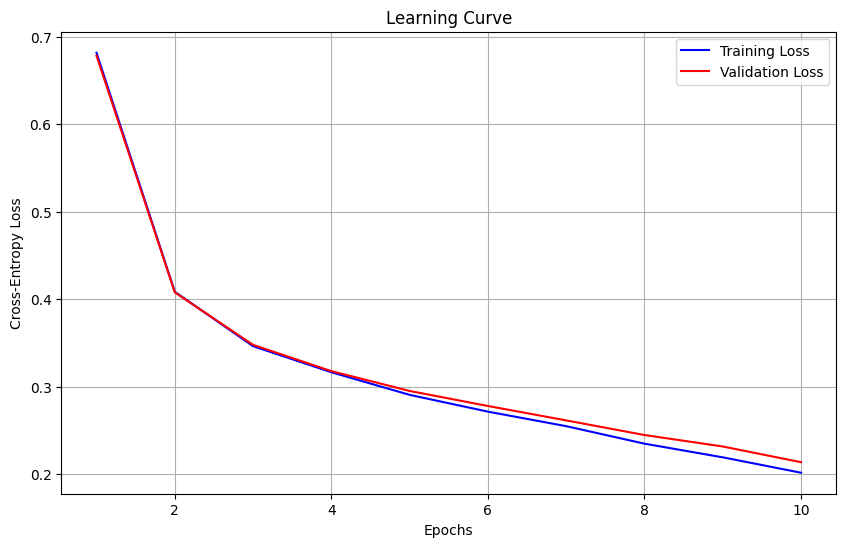

Making predictions...
Shapes -> y_pred_test: (10000,), y_test_original: (10000,)
Validation accuracy: 0.9385
Test accuracy: 0.9392
Visualizing misclassifications...


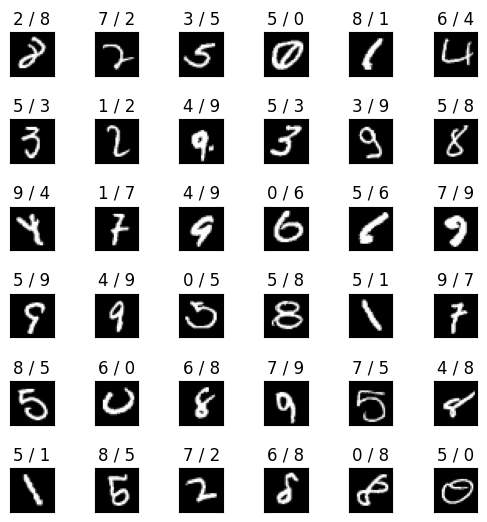

In [4]:
def main():
    # Load and preprocess data
    print("Loading and preprocessing MNIST dataset...")
    X_train, X_val, X_test, y_train, y_val, y_test, y_train_original, y_val_original, y_test_original = load_and_preprocess_mnist()
    
    # Ensure original labels are in the correct format
    if y_train_original.ndim > 1:
        y_train_original = np.argmax(y_train_original, axis=1)
    if y_val_original.ndim > 1:
        y_val_original = np.argmax(y_val_original, axis=1)
    if y_test_original.ndim > 1:
        y_test_original = np.argmax(y_test_original, axis=1)
    
    # Create and train the model
    print("Creating and training neural network...")
    model = ScratchSimpleNeuralNetrowkClassifier(
        n_nodes1=400, 
        n_nodes2=200, 
        learning_rate=0.01,
        epochs=10, 
        batch_size=20, 
        activation='tanh',
        random_state=42, 
        verbose=True
    )
    
    model.fit(X_train, y_train, X_val, y_val)
    
    # Plot learning curve
    print("Plotting learning curve...")
    plot_learning_curve(model)
    
    # Make predictions
    print("Making predictions...")
    y_pred_val = np.array(model.predict(X_val)).ravel()
    y_pred_test = np.array(model.predict(X_test)).ravel()
    
    # Ensure predicted values match the ground truth format
    if y_pred_val.ndim > 1:
        y_pred_val = np.argmax(y_pred_val, axis=1)
    if y_pred_test.ndim > 1:
        y_pred_test = np.argmax(y_pred_test, axis=1)
    
    # Convert ground truth labels to NumPy arrays
    y_val_original = np.array(y_val_original).ravel()
    y_test_original = np.array(y_test_original).ravel()
    
    # Check and print shapes
    print(f"Shapes -> y_pred_test: {y_pred_test.shape}, y_test_original: {y_test_original.shape}")

    # Calculate accuracy using elementwise comparison
    val_accuracy = np.mean(y_pred_val == y_val_original)
    test_accuracy = np.mean(y_pred_test == y_test_original)
    
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    # Visualize misclassifications
    print("Visualizing misclassifications...")
    visualize_misclassifications(y_pred_val, y_val_original, X_val)

if __name__ == "__main__":
    main()
